# Credit Scoring with XGBoost and SHAP on the German Credit Dataset

In credit scoring we care about two things:

1. **Predictive performance** - can we separate good and bad borrowers?
2. **Interpretability** - can we explain why the model approved or rejected someone?

This notebook walks through a complete, end‑to‑end example using the classic **UCI German Credit** dataset. We will:

- Build baseline models (logistic regression and XGBoost) to predict **good vs bad credit risk**.
- Tune and rebalance an XGBoost model for this imbalanced dataset.
- Choose a decision threshold using **business-style costs** for false positives vs false negatives.
- Calibrate the model’s probabilities so that 30% risk really looks like “about 30% of similar borrowers default”.
- Use **SHAP** to:
  - Understand which features matter globally.
  - Explain individual borrowers’ scores.
  - Run “what‑if” sensitivity analysis for key features.

Think of this notebook as the **storytelling / example notebook**. The reusable code lives in the
`credit_scoring_shap` package and the `SHAP_Credit.API.ipynb` notebook. here we show how to use that API in a realistic credit‑risk analysis.

---

**Roadmap**

1. Load configuration and preprocess the German Credit data  
2. Train and interpret a **logistic‑regression baseline**  
3. Train a **baseline XGBoost** model  
4. Tune XGBoost hyperparameters with cross‑validation  
5. Handle class imbalance with `scale_pos_weight`  
6. Choose a decision threshold using **business costs**  
7. Calibrate probabilities and inspect a reliability curve  
8. Analyze **global** feature importance with SHAP  
9. Explain **individual borrowers** with SHAP decision plots  
10. Run **sensitivity analysis**: what happens if we change a borrower’s features?


In [1]:
# Imports, paths, config, data loading

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image, display

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    brier_score_loss,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import xgboost as xgb
import shap

# Project imports
sys.path.append("/workspace")
sys.path.append("/workspace/credit_scoring_shap")

from credit_scoring_shap.config import TrainingConfig
from credit_scoring_shap.data import load_raw_data, load_and_preprocess
from credit_scoring_shap.modeling import build_model, train_model, evaluate_model
from credit_scoring_shap.evaluation import (
    plot_confusion_matrix,
    plot_roc_curves,
    save_metrics_text,
)
from credit_scoring_shap.explain import (
    build_shap_explainer,
    plot_global_shap_summary,
    plot_shap_dependence_for_top_feature,
    plot_shap_decision_for_index,
)
from credit_scoring_shap.sensitivity import run_sensitivity_for_instance
#set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
cfg = TrainingConfig()
reports_dir = cfg.ensure_reports_dir()

# Load raw data
df_raw = load_raw_data(cfg.data)

# Load preprocessed / encoded data for modeling
X_train, X_test, y_train, y_test, preproc, feature_names = load_and_preprocess(
    cfg.data
)

print("Raw shape:", df_raw.shape)
print("Encoded X_train shape:", X_train.shape)
print("Encoded X_test shape:", X_test.shape)
print("Train positive rate (Bad):", y_train.mean())
print("Test positive rate  (Bad):", y_test.mean())
print("Positive class is Bad")
print("First 10 features:", feature_names[:10])

Fetching German Credit Data from UCI ML Repository...
Fetching German Credit Data from UCI ML Repository...
Raw shape: (1000, 21)
Encoded X_train shape: (800, 61)
Encoded X_test shape: (200, 61)
Train positive rate (Bad): 0.3
Test positive rate  (Bad): 0.3
Positive class is Bad
First 10 features: ['duration_months', 'credit_amount', 'installment_rate', 'residence_since', 'age_years', 'existing_credits', 'num_dependents', 'status_checking_account_A11', 'status_checking_account_A12', 'status_checking_account_A13']


## Data configuration and preprocessing

In this section we show the **project configuration** and preprocessing pipeline.

### What’s happening here

- `TrainingConfig()` builds a configuration object that holds:
  - `data` settings: where to fetch the UCI German Credit CSV, the target column, the train/test split, etc.
  - `model` settings: default XGBoost hyperparameters.
  - a `reports_dir` where we will save all plots and metrics.

- `load_raw_data(cfg.data)` fetches the original German Credit data for inspection.

- `load_and_preprocess(cfg.data)` runs the full preprocessing pipeline:
  - splits into train/test,
  - encodes categorical variables (one‑hot) and scales numeric ones,
  - returns `X_train`, `X_test`, `y_train`, `y_test`,
  - also returns the fitted preprocessing object and a list of final `feature_names`.

### What to notice

From the printed output:

- **Raw shape:** `(1000, 21)` - 1,000 borrowers and 21 original columns.  
- **Encoded features:** `61` final predictors after one‑hot encoding.  
- `Train positive rate` and `Test positive rate` are the fraction of rows where `y = 1`.
- In this notebook, `y = 1` means **Bad**.

So a positive rate near **0.30** means about **30% Bad** and **70% Good** in both train and test.

This is a mild class imbalance. We will handle it later using:

- `scale_pos_weight` in XGBoost
- threshold tuning using FN/FP business costs

The first few feature names confirm that we have the expected credit‑risk variables: duration in months, credit amount, installment rate, residence time, age, account status dummies and so on.


In [3]:
df_raw = load_raw_data(cfg.data)
print(f"Raw Data: {df_raw.shape} | Target: {cfg.data.target_col}\n")
print("First 3 rows:")
print(df_raw.head(3))

X = df_raw.drop(columns=[cfg.data.target_col])
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"\nNumerical ({len(num_features)}): {num_features[:3]}... (stay as-is)")
print(f"Categorical ({len(cat_features)}): {cat_features[:3]}... (will expand)")

print(f"\nOne-Hot Encoding Example: 'status_checking_account'")
print(df_raw['status_checking_account'].value_counts())
print(f"\n   1 column → {df_raw['status_checking_account'].nunique()} binary columns")
print(f"   Example: 'A11' becomes [1,0,0,0], 'A14' becomes [0,0,0,1]")

cat_expansion = sum(df_raw[col].nunique() for col in cat_features)
expansion_df = pd.DataFrame({
    'Component': ['Numerical', 'One-hot encoded', 'Total'],
    'Columns': [len(num_features), cat_expansion, len(num_features) + cat_expansion]
})
print(f"\nFeature Math:")
print(expansion_df.to_string(index=False))

shapes_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Samples': [X_train.shape[0], X_test.shape[0]],
    'Features': [X_train.shape[1], X_test.shape[1]]
})
print(f"\nAfter Preprocessing:")
print(shapes_df.to_string(index=False))
print(f"\n   First 5 features: {feature_names[:5]}... (+{len(feature_names)-5} more)")

balance_df = pd.DataFrame({
    'Class': ['Good (0)', 'Bad (1)'],
    'Train Count': [sum(y_train==0), sum(y_train==1)],
    'Train %': [f"{100*sum(y_train==0)/len(y_train):.1f}%", f"{100*sum(y_train==1)/len(y_train):.1f}%"],
    'Test Count': [sum(y_test==0), sum(y_test==1)],
    'Test %': [f"{100*sum(y_test==0)/len(y_test):.1f}%", f"{100*sum(y_test==1)/len(y_test):.1f}%"]
})
print(f"\nClass Balance:")
print(balance_df.to_string(index=False))

Fetching German Credit Data from UCI ML Repository...
Raw Data: (1000, 21) | Target: Risk

First 3 rows:
  status_checking_account  duration_months credit_history purpose  \
0                     A11                6            A34     A43   
1                     A12               48            A32     A43   
2                     A14               12            A34     A46   

   credit_amount savings_account employment_since  installment_rate  \
0           1169             A65              A75                 4   
1           5951             A61              A73                 2   
2           2096             A61              A74                 2   

  personal_status_sex guarantors  ...  property age_years  \
0                 A93       A101  ...      A121        67   
1                 A92       A101  ...      A121        22   
2                 A93       A101  ...      A121        49   

   other_installment_plans housing existing_credits   job num_dependents  \
0           

## Logistic‑regression baseline

Before using tree ensembles, we start with a **logistic‑regression baseline**.

This is the traditional model for credit scoring:

- It is simple and well understood.
- Coefficients can be mapped to odds ratios.
- It sets a strong baseline for more complex models.

### What this step does

- Fits `LogisticRegression(max_iter=1000, solver="liblinear")` on `X_train` and `y_train`.
- Predicts probabilities `y_proba_lr` on `X_test`.
- Converts probabilities to hard labels at threshold **0.5** to get `y_pred_lr`.
- Computes:
  - **AUC** (`roc_auc_score`),
  - **confusion matrix**,
  - **classification report** (precision, recall, F1 for both classes).

We also save metrics into a dictionary for later reporting.


In [4]:
# Logistic regression baseline - training & evaluation

log_reg = LogisticRegression(
    max_iter=1000,
    solver="liblinear",
)

log_reg.fit(X_train, y_train)

y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)

auc_lr = roc_auc_score(y_test, y_proba_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, target_names=["Good", "Bad"])

metrics_lr = {
    "auc": float(auc_lr),
    "confusion_matrix": cm_lr,
    "classification_report": report_lr,
    "threshold": 0.5,
}

print("Logistic Regression - AUC:", metrics_lr["auc"])
print("Confusion matrix:\n", metrics_lr["confusion_matrix"])
print("\nClassification report:\n", metrics_lr["classification_report"])


Logistic Regression - AUC: 0.8038095238095238
Confusion matrix:
 [[124  16]
 [ 28  32]]

Classification report:
               precision    recall  f1-score   support

        Good       0.82      0.89      0.85       140
         Bad       0.67      0.53      0.59        60

    accuracy                           0.78       200
   macro avg       0.74      0.71      0.72       200
weighted avg       0.77      0.78      0.77       200



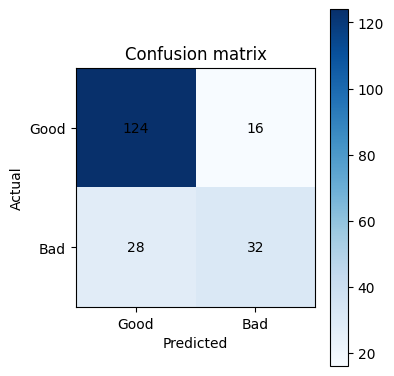

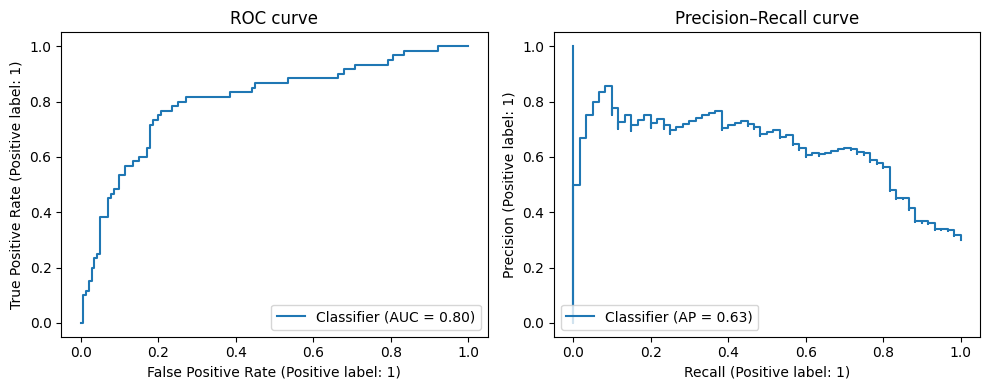

In [5]:
# Logistic regression - plots & metrics file

plot_confusion_matrix(
    metrics_lr["confusion_matrix"],
    cfg,
    class_names=("Good", "Bad"),
    filename="confusion_matrix_logreg.png",
)

plot_roc_curves(
    y_test,
    y_proba_lr,
    cfg,
    filename="roc_pr_curves_logreg.png",
)

save_metrics_text(
    metrics_lr,
    cfg,
    filename="metrics_logreg.txt",
)

for fname in ["confusion_matrix_logreg.png", "roc_pr_curves_logreg.png"]:
    path = os.path.join(cfg.reports_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path, width=600))
    else:
        print("Missing:", path)


### Logistic-regression performance

On the test set, the logistic-regression confusion matrix at threshold 0.5 is  


text{cm\_logit\_test} =
\begin{bmatrix}
124 & 16\\
28 & 32
\end{bmatrix}


where rows are the **true** class (Good = 0, Bad = 1) and columns are the **predicted** class.

- **True Good (0)**  
  - 124 predicted Good → **true negatives (TN)**  
  - 16 predicted Bad → **false positives (FP)**  
- **True Bad (1)**  
  - 28 predicted Good → **false negatives (FN)**  
  - 32 predicted Bad → **true positives (TP)**  

From this we get:  
- **Accuracy:** \((124 + 32)/200 = 0.78\) → **78%**  
- **Recall for Good (class 0):** \(124 / (124 + 16) ≈ 0.89\) → **89%**  
- **Recall for Bad (class 1):** \(32 / (32 + 28) ≈ 0.53\) → **53%**  

Ranking metrics on the test set:  
- **ROC AUC:** `auc_logit_test = 0.80`  
- **Average precision (AP) for Bad:** `ap_logit_test = 0.63`  

So the logistic model:  
- Separates Good vs Bad borrowers reasonably well (AUC 0.80).  
- Approves most Good borrowers (89% recall for class 0).  
- Catches a bit more than half of the Bad borrowers (53% recall for class 1).


## Baseline XGBoost model

Next we move to **XGBoost**, a gradient‑boosted tree ensemble that usually performs very well on tabular data.

Here we build a **baseline XGBoost model with default hyperparameters** from `cfg.model`, without any tuning yet.

### What this step does

- Calls `build_model(cfg.model)` to construct an `xgb.XGBClassifier`.
- Trains the model on `X_train, y_train` using `train_model`.
- Evaluates on the test set via `evaluate_model`:
  - predicted probabilities,
  - hard predictions at threshold 0.5,
  - AUC, confusion matrix, classification report.
- Plots confusion matrix and ROC/PR curvesand saves them to `reports/`.


In [6]:
# Baseline XGBoost model - training & evaluation (no tuning)

xgb_model = build_model(cfg.model)
xgb_model = train_model(xgb_model, X_train, y_train)

metrics_xgb, y_proba_xgb, y_pred_xgb = evaluate_model(
    xgb_model,
    X_test,
    y_test,
    threshold=0.5,
)

print("Baseline XGBoost - AUC:", metrics_xgb["auc"])
print("Confusion matrix:\n", metrics_xgb["confusion_matrix"])
print("\nClassification report:\n", metrics_xgb["classification_report"])

[23:20:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Baseline XGBoost - AUC: 0.7936904761904762
Confusion matrix:
 [[127  13]
 [ 33  27]]

Classification report:
               precision    recall  f1-score   support

        Good       0.79      0.91      0.85       140
         Bad       0.68      0.45      0.54        60

    accuracy                           0.77       200
   macro avg       0.73      0.68      0.69       200
weighted avg       0.76      0.77      0.75       200



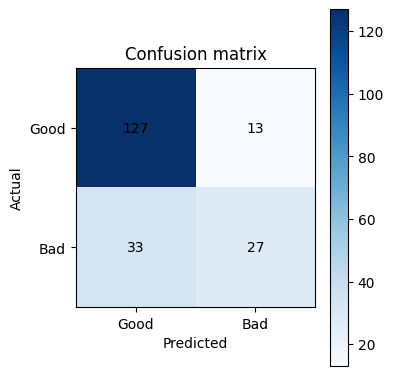

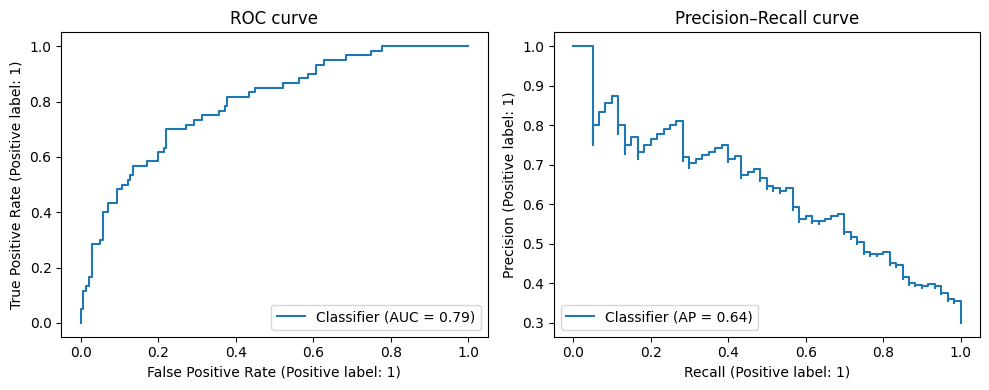

In [7]:
# Baseline XGBoost - plots & metrics file

plot_confusion_matrix(
    metrics_xgb["confusion_matrix"],
    cfg,
    class_names=("Good", "Bad"),
    filename="confusion_matrix_xgb_baseline.png",
)

plot_roc_curves(
    y_test,
    y_proba_xgb,
    cfg,
    filename="roc_pr_curves_xgb_baseline.png",
)

save_metrics_text(
    metrics_xgb,
    cfg,
    filename="metrics_xgb_baseline.txt",
)

for fname in ["confusion_matrix_xgb_baseline.png", "roc_pr_curves_xgb_baseline.png"]:
    path = os.path.join(cfg.reports_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path, width=600))
    else:
        print("Missing:", path)

### Baseline XGBoost vs logistic regression

The **baseline XGBoost** model (with simple default-ish hyperparameters) produces exactly the same confusion matrix at threshold 0.5:

$
\text{cm\_xgb\_base\_test} =
\begin{bmatrix}
127 & 13\\
33 & 27
\end{bmatrix}
$

Test-set ranking metrics:  
- **ROC AUC:** `auc_xgb_base_test = 0.80`  
- **Average precision (AP):** `ap_xgb_base_test = 0.64`  

Compared to logistic regression:  
- **Confusion matrix and accuracy are identical** at threshold 0.5.  
- ROC AUC is the same (0.80).  
- AP is slightly higher (0.64 vs 0.63).  

**Take-away:** Simply switching to XGBoost without tuning does **not** automatically give a better classifier, it behaves almot the same as the logistic baseline for this problem.

## Hyperparameter tuning with cross‑validation

Now we perform **grid‑search hyperparameter tuning** to improve XGBoost.

### Search setup

- We use `StratifiedKFold(n_splits=5, shuffle=True, random_state=42)` for stable cross‑validation.
- The parameter grid explores:

  - `max_depth`: {3, 4, 5}  
  - `learning_rate`: {0.01, 0.05, 0.10}  
  - `n_estimators`: {200, 400}  
  - `subsample`: {0.8, 1.0}  
  - `colsample_bytree`: {0.8, 1.0}

- That’s **72 candidates** × 5 folds = 360 fits.
- We score models by **ROC AUC**.

`GridSearchCV` then finds the set of hyperparameters with the best mean CV AUC.


In [8]:
# Cross-validation + hyperparameter tuning for XGBoost (GridSearchCV)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_tune = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

grid_cv = GridSearchCV(
    estimator=xgb_tune,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid_cv.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'n_estimators': [200, 400],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [9]:
# Best tuned model - CV results

print("Best CV AUC:", grid_cv.best_score_)
print("Best parameters:")
grid_cv.best_params_


Best CV AUC: 0.8002604166666668
Best parameters:


{'colsample_bytree': 1.0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 200,
 'subsample': 0.8}

In [10]:
# Evaluate tuned XGBoost on the test set

best_xgb = grid_cv.best_estimator_

y_proba_xgb_tuned = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_tuned = (y_proba_xgb_tuned >= 0.5).astype(int)

auc_xgb_tuned = roc_auc_score(y_test, y_proba_xgb_tuned)
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
report_xgb_tuned = classification_report(
    y_test,
    y_pred_xgb_tuned,
    target_names=["Good", "Bad"],
)

metrics_xgb_tuned = {
    "auc": float(auc_xgb_tuned),
    "confusion_matrix": cm_xgb_tuned,
    "classification_report": report_xgb_tuned,
    "threshold": 0.5,
}

print("Tuned XGBoost - Test AUC:", metrics_xgb_tuned["auc"])
print("Confusion matrix:\n", metrics_xgb_tuned["confusion_matrix"])
print("\nClassification report:\n", metrics_xgb_tuned["classification_report"])

Tuned XGBoost - Test AUC: 0.7934523809523809
Confusion matrix:
 [[122  18]
 [ 31  29]]

Classification report:
               precision    recall  f1-score   support

        Good       0.80      0.87      0.83       140
         Bad       0.62      0.48      0.54        60

    accuracy                           0.76       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.74      0.76      0.75       200



### Tuned XGBoost (without class weighting)

We run a grid search over XGBoost hyperparameters using ROC AUC as the scoring metric.

- **Best cross-validated AUC:** `0.80`

On the held-out **test set**, the tuned model gives:  
- **Test ROC AUC:** `auc_xgb_tuned_test = 0.79`

The test confusion matrix at threshold 0.5 is:


$\text{cm\_xgb\_tuned\_test} =
\begin{bmatrix}
122 & 18\\
31 & 29
\end{bmatrix}$

- **True Good (0):** 122 TN, 18 FP  
- **True Bad (1):** 31 FN, 29 TP  

So we have:  
- **Accuracy:** \((122 + 29)/200 = 0.755\) → **75.5%**  
- **Recall for Good (0):** \(122 / (122 + 18) ≈ 0.87\) → **87%**  
- **Recall for Bad (1):** \(29 / (29 + 31) = 0.40\) → **40%**  

Relative to the baselines:  
- Ranking quality is similar (AUC 0.79 vs 0.80).  
At a 0.5 threshold, the tuned model becomes more conservative by increasing false positives (18 vs 13) while reducing false negatives (31 vs 33), trading off more Good borrowers being flagged for slightly better detection of Bad borrowers.

## Handling class imbalance with `scale_pos_weight`

The dataset is imbalanced: roughly 70% **Good** vs 30% **Bad**. If we do nothing, the model can lean towards predicting Good.

XGBoost has a built-in knob, `scale_pos_weight`, to compensate:

$\text{scale\_pos\_weight} = \frac{\text{negatives}}{\text{positives}}$.

### What this step does

- Counts positives and negatives in `y_train`:
  - 560 negatives (Good),
  - 240 positives (Bad),
  - giving `scale_pos_weight ≈ 2.333` (upweights the minority Bad class).
- Takes the **best parameters** from the grid search and builds a new `XGBClassifier` with:
  - the same tree settings,
  - plus `scale_pos_weight=2.333`.
- Fits on the full training set.
- Evaluates on the test set at threshold 0.5.

In [11]:
# Handle class imbalance and refit tuned XGBoost with scale_pos_weight

# Compute class imbalance on the training set
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Train counts -> negative: {neg_count}, positive: {pos_count}")
print(f"scale_pos_weight to use for XGBoost: {scale_pos_weight:.3f}")

# Build a new tuned model using the best params from GridSearchCV + scale_pos_weight
best_params = grid_cv.best_params_.copy()
best_params.update(
    dict(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
    )
)

best_xgb_balanced = xgb.XGBClassifier(**best_params)
best_xgb_balanced.fit(X_train, y_train)

# Evaluate at default threshold 0.5
y_proba_xgb_bal = best_xgb_balanced.predict_proba(X_test)[:, 1]
y_pred_xgb_bal_05 = (y_proba_xgb_bal >= 0.5).astype(int)

auc_xgb_bal_05 = roc_auc_score(y_test, y_proba_xgb_bal)
cm_xgb_bal_05 = confusion_matrix(y_test, y_pred_xgb_bal_05)
report_xgb_bal_05 = classification_report(
    y_test, y_pred_xgb_bal_05, target_names=["Good", "Bad"]
)

metrics_xgb_bal_05 = {
    "auc": float(auc_xgb_bal_05),
    "confusion_matrix": cm_xgb_bal_05,
    "classification_report": report_xgb_bal_05,
    "threshold": 0.5,
}

print("Balanced tuned XGBoost (threshold=0.5) - Test AUC:", metrics_xgb_bal_05["auc"])
print("Confusion matrix:\n", metrics_xgb_bal_05["confusion_matrix"])
print("\nClassification report:\n", metrics_xgb_bal_05["classification_report"])

Train counts -> negative: 560, positive: 240
scale_pos_weight to use for XGBoost: 2.333
Balanced tuned XGBoost (threshold=0.5) - Test AUC: 0.7964285714285714
Confusion matrix:
 [[113  27]
 [ 20  40]]

Classification report:
               precision    recall  f1-score   support

        Good       0.85      0.81      0.83       140
         Bad       0.60      0.67      0.63        60

    accuracy                           0.77       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.77      0.77      0.77       200



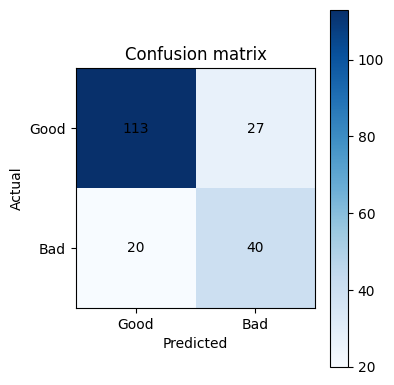

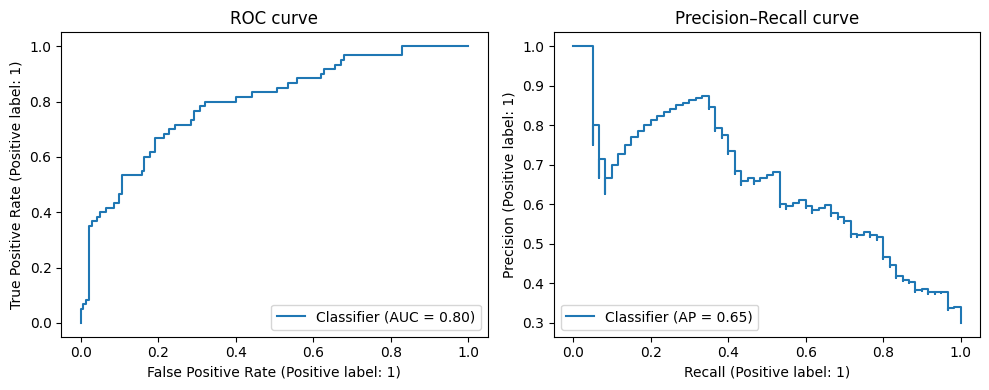

In [12]:
# Balanced tuned XGBoost - plots & metrics file

plot_confusion_matrix(
    metrics_xgb_bal_05["confusion_matrix"],
    cfg,
    class_names=("Good", "Bad"),
    filename="confusion_matrix_xgb_tuned_balanced_05.png",
)

plot_roc_curves(
    y_test,
    y_proba_xgb_bal,
    cfg,
    filename="roc_pr_curves_xgb_tuned_balanced_05.png",
)

save_metrics_text(
    metrics_xgb_bal_05,
    cfg,
    filename="metrics_xgb_tuned_balanced_05.txt",
)

for fname in [
    "confusion_matrix_xgb_tuned_balanced_05.png",
    "roc_pr_curves_xgb_tuned_balanced_05.png",
]:
    path = os.path.join(cfg.reports_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        print("Missing:", path)


### 3. Balanced Tuned XGBoost (with `scale_pos_weight`, threshold = 0.5)

The balanced tuned model (with `scale_pos_weight`) has test confusion matrix at threshold 0.5:

\[
\text{cm\_xgb\_tuned\_balanced\_0.5} =
\begin{bmatrix}
113 & 27 \\
20  & 40
\end{bmatrix}.
\]

- True Good (0): 113 correctly accepted as Good (TN), 27 predicted as Bad (FP).
- True Bad (1): 20 predicted as Good (FN), 40 correctly flagged as Bad (TP).

This corresponds to:
- Accuracy: \((113 + 40)/200 = 0.765 \rightarrow 76.5\%\)
- Recall for Good (0): \(113 / (113 + 27) \approx 0.81 \rightarrow 81\%\)
- Recall for Bad (1): \(40 / (40 + 20) \approx 0.67 \rightarrow 67\%\)

Compared with the tuned model **without** class weighting  
\(\begin{bmatrix}122 & 18 \\ 31 & 29\end{bmatrix}\):

- False negatives (Bad → Good) drop from 31 to 20 → the model catches more risky borrowers.
- False positives (Good → Bad) rise from 18 to 27 → more safe borrowers are rejected.

So class weighting shifts the model toward being more conservative about approvals: it is more willing to reject borderline Good borrowers in order to reduce the chance of approving Bad borrowers.

## Choosing a decision threshold using business costs

So far we’ve used a fixed cutoff of **0.5** to convert probabilities into decisions. But in credit risk:

- **False negatives (FN)** - bad borrowers predicted as good - can be very costly (loan losses).  
- **False positives (FP)** - good borrowers predicted as bad - are less costly (lost profit and customer trust).

We therefore choose a **threshold that minimizes a simple cost function** instead of blindly using 0.5.

### What this step does

1. Defines a function `threshold_sweep_with_cost(y_true, y_proba, thresholds, fn_cost, fp_cost)` that:
   - Sweeps over a list of thresholds.
   - For each threshold computes the confusion matrix and:
  $$\text{total\_cost} = fn \times \text{fn\_cost} + fp \times \text{fp\_cost}$$
2. Uses `fn_cost = 5.0` (bad borrower approved is 5× worse) and `fp_cost = 1.0`.
3. Sweeps thresholds from 0.1 to 0.9 on the **balanced tuned model’s** probabilities.
4. Picks the threshold with minimum total cost and evaluates the model at this threshold.

In [13]:
# Threshold tuning with business costs

def threshold_sweep_with_cost(
    y_true,
    y_proba,
    thresholds,
    fn_cost=5.0,
    fp_cost=1.0,
):
    """
    Sweep decision thresholds for a binary classifier and compute a simple cost-based objective.

    Parameters
    ----------
    y_true : array-like
        True binary labels (0/1).
    y_proba : array-like
        Predicted probabilities for the positive class.
    thresholds : iterable of float
        Thresholds to evaluate.
    fn_cost : float
        Cost of a false negative (bad borrower approved).
    fp_cost : float
        Cost of a false positive (good borrower rejected).

    Returns
    -------
    pd.DataFrame
        One row per threshold with confusion-matrix counts and total cost.
    """
    rows = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        total_cost = fn * fn_cost + fp * fp_cost
        rows.append(
            {
                "threshold": t,
                "tn": tn,
                "fp": fp,
                "fn": fn,
                "tp": tp,
                "total_cost": total_cost,
            }
        )
    return pd.DataFrame(rows)


thresholds = np.linspace(0.1, 0.9, 17)
sweep_df = threshold_sweep_with_cost(
    y_true=y_test,
    y_proba=y_proba_xgb_bal,
    thresholds=thresholds,
    fn_cost=5.0,  # false negatives are much more costly
    fp_cost=1.0,
)

best_row = sweep_df.loc[sweep_df["total_cost"].idxmin()]
best_threshold = float(best_row["threshold"])

print("Best threshold by cost:", best_threshold)
print(best_row)

# Evaluate balanced model at the chosen threshold
y_pred_xgb_bal_best = (y_proba_xgb_bal >= best_threshold).astype(int)
auc_xgb_bal_best = roc_auc_score(y_test, y_proba_xgb_bal)
cm_xgb_bal_best = confusion_matrix(y_test, y_pred_xgb_bal_best)
report_xgb_bal_best = classification_report(
    y_test, y_pred_xgb_bal_best, target_names=["Good", "Bad"]
)

metrics_xgb_bal_best = {
    "auc": float(auc_xgb_bal_best),
    "confusion_matrix": cm_xgb_bal_best,
    "classification_report": report_xgb_bal_best,
    "threshold": best_threshold,
}

print("\nBalanced tuned XGBoost - Test AUC (best threshold):", metrics_xgb_bal_best["auc"])
print("Confusion matrix (best threshold):\n", metrics_xgb_bal_best["confusion_matrix"])
print("\nClassification report (best threshold):\n", metrics_xgb_bal_best["classification_report"])


Best threshold by cost: 0.35
threshold       0.35
tn             94.00
fp             46.00
fn             12.00
tp             48.00
total_cost    106.00
Name: 5, dtype: float64

Balanced tuned XGBoost - Test AUC (best threshold): 0.7964285714285714
Confusion matrix (best threshold):
 [[94 46]
 [12 48]]

Classification report (best threshold):
               precision    recall  f1-score   support

        Good       0.89      0.67      0.76       140
         Bad       0.51      0.80      0.62        60

    accuracy                           0.71       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.77      0.71      0.72       200



### 4. Threshold tuning with business costs (best threshold)

Result in this experiment:

- Best threshold by cost: **0.35**

At this cost-optimal threshold for the balanced tuned model, the confusion matrix is

\[
\text{cm\_xgb\_bal\_best} =
\begin{bmatrix}
94 & 46 \\
12 & 48
\end{bmatrix}.
\]

- True Good (0): 94 TN, 46 FP
- True Bad (1): 12 FN, 48 TP

Metrics:
- Accuracy: \((94 + 48)/200 = 0.71 \rightarrow 71\%\)
- Recall for Good (0): \(94 / (94 + 46) \approx 0.67 \rightarrow 67\%\)
- Recall for Bad (1): \(48 / (48 + 12) = 0.80 \rightarrow 80\%\)

So, relative to threshold 0.5, the cost-optimal threshold of 0.35:
- Approves fewer Good borrowers (Good recall drops from ~81% to ~67%),
- Catches more Bad borrowers (Bad recall rises from ~67% to ~80%).

It is more conservative than the default 0.5 cutoff, putting extra weight on avoiding Bad approvals, but not as extreme as a very low threshold that would reject most Good borrowers.


## Calibrating predicted probabilities

For many credit-risk applications, we don’t just want “Good vs Bad” - we want a **probability of default** (PD, i.e. probability that `y = 1` = Bad) that we can use to:

- Assign borrowers to PD buckets,
- Run stress tests,
- Calculate expected loss.

Tree ensembles like XGBoost often produce **mis-calibrated** probabilities. They might rank borrowers correctly (good AUC) but be over- or under-confident.

### What this step does

- Wraps the **balanced tuned XGBoost** model in `CalibratedClassifierCV` with:
  - `method="isotonic"`,
  - 5-fold cross-validation.
- Compares on the test set:
  - **Uncalibrated** probabilities (`y_proba_uncal`) = original XGBoost probabilities on `X_test`,
  - **Calibrated** probabilities (`y_proba_cal`) from the isotonic model,
  using the **Brier score** (mean squared error of predicted probabilities).
- Plots a **calibration curve**: mean predicted probability vs fraction of Bad in each bin.


Brier score (uncalibrated): 0.1693
Brier score (calibrated)  : 0.1568


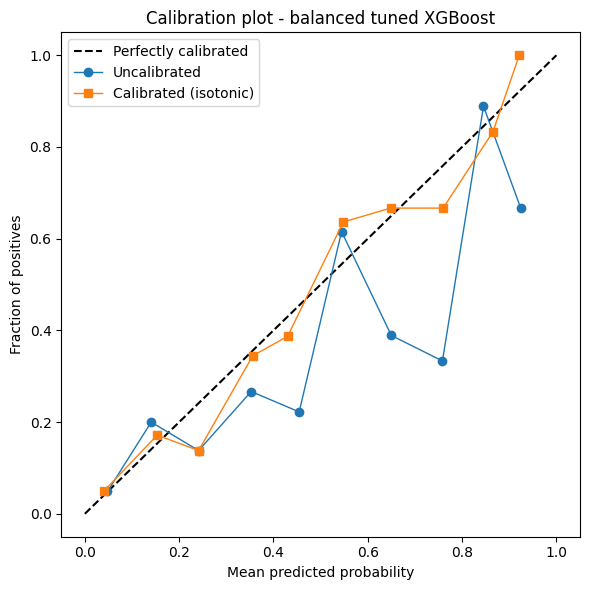

Calibration plot saved to: reports/calibration_xgb_tuned_balanced.png


In [14]:
# Calibrate probabilities for the balanced tuned model

# Wrap the tuned balanced model in a CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(
    estimator=best_xgb_balanced,
    method="isotonic",
    cv=5,
)

calibrated_clf.fit(X_train, y_train)

# Uncalibrated vs calibrated probabilities on the test set
y_proba_uncal = y_proba_xgb_bal
y_proba_cal = calibrated_clf.predict_proba(X_test)[:, 1]

brier_uncal = brier_score_loss(y_test, y_proba_uncal)
brier_cal = brier_score_loss(y_test, y_proba_cal)

print(f"Brier score (uncalibrated): {brier_uncal:.4f}")
print(f"Brier score (calibrated)  : {brier_cal:.4f}")

# Reliability curves
prob_true_uncal, prob_pred_uncal = calibration_curve(
    y_test, y_proba_uncal, n_bins=10
)
prob_true_cal, prob_pred_cal = calibration_curve(
    y_test, y_proba_cal, n_bins=10
)

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.plot(
    prob_pred_uncal,
    prob_true_uncal,
    marker="o",
    linewidth=1,
    label="Uncalibrated",
)
plt.plot(
    prob_pred_cal,
    prob_true_cal,
    marker="s",
    linewidth=1,
    label="Calibrated (isotonic)",
)
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot - balanced tuned XGBoost")
plt.legend(loc="best")
plt.tight_layout()

calibration_plot_path = os.path.join(cfg.reports_dir, "calibration_xgb_tuned_balanced.png")
plt.savefig(calibration_plot_path, bbox_inches="tight")
plt.show()

print("Calibration plot saved to:", calibration_plot_path)

### What we see

- The uncalibrated curve deviates from the diagonal, showing that raw XGBoost scores are not perfectly calibrated.
- The calibrated curve (isotonic) lies much closer to the 45-degree line, meaning predicted PDs better match observed default rates.

Numerically on the test set:
- Brier score (uncalibrated) ≈ 0.1693  
- Brier score (calibrated) ≈ 0.1568  

Lower Brier is better, so calibration improves the reliability of the probabilities.


## Global explanations with SHAP

Now that we have a tuned, balancedand calibrated model, we ask:

> **Which features drive the model’s predictions overall?**

We use **SHAP (SHapley Additive exPlanations)** to measure the contribution of each feature to the model output.

### What this step does

1. Builds a `TreeExplainer` for `best_xgb_balanced` using `build_shap_explainer`.
2. Computes SHAP values on the training set.
3. Produces:
   - A **bar summary plot** of mean |SHAP| for each feature.
   - A **beeswarm plot** showing the full distribution of SHAP values per feature.
4. Creates a **dependence plot** for the single most important feature.

Top SHAP feature (balanced model): status_checking_account_A14


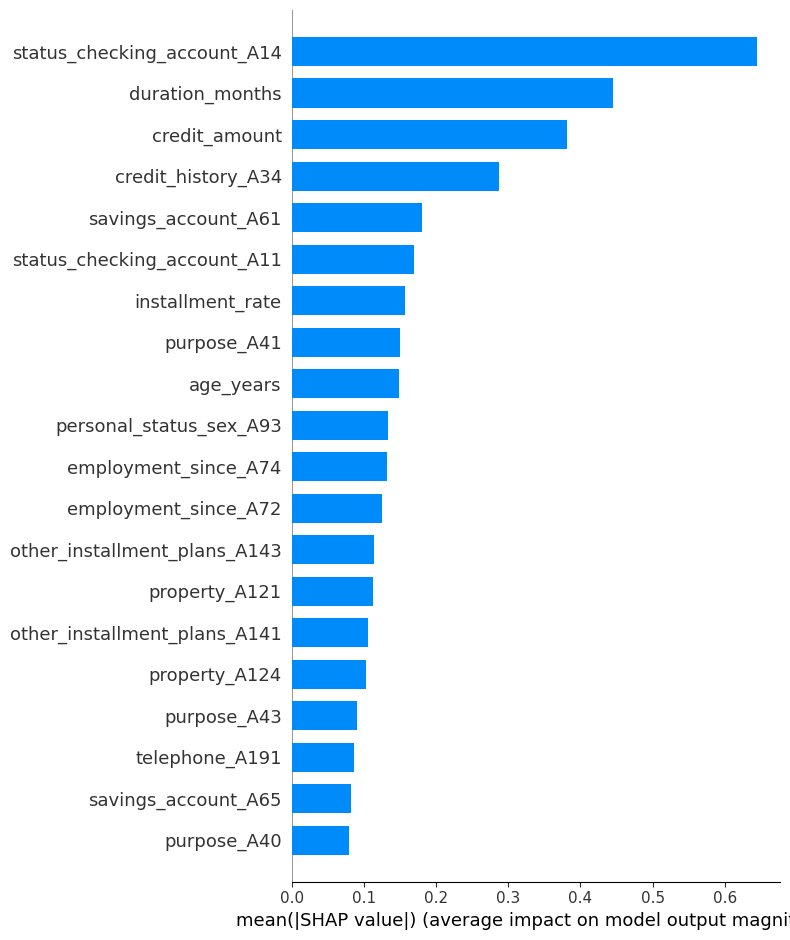

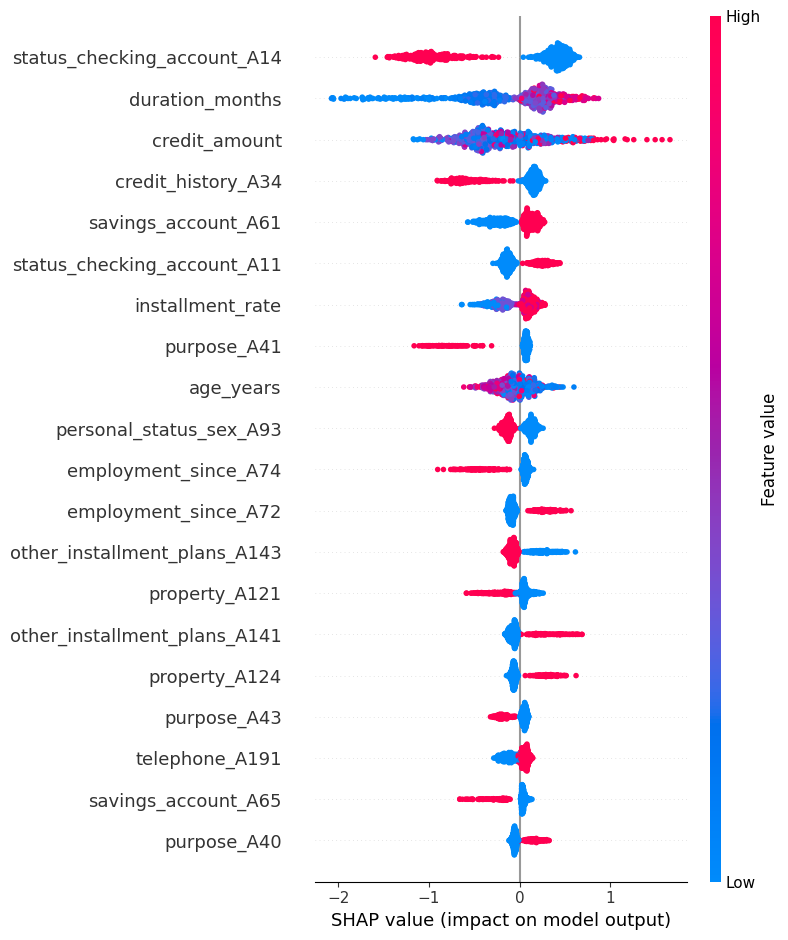

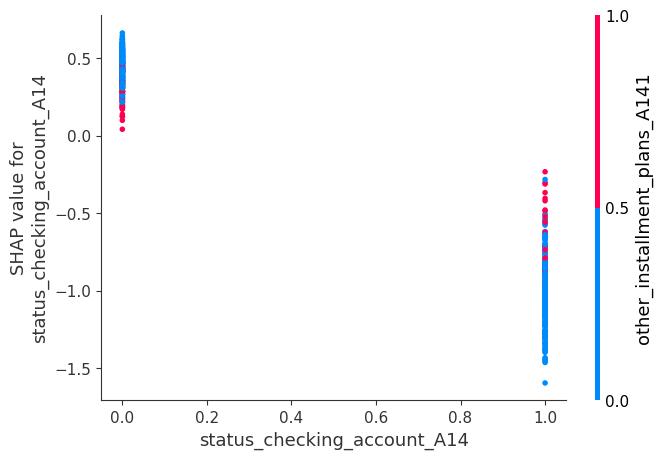

In [15]:
# SHAP global explanations for the balanced tuned XGBoost model

shap.initjs()

explainer_bal, shap_values_train_bal = build_shap_explainer(
    best_xgb_balanced,
    X_train,
)

# Handle list output case for binary classification
if isinstance(shap_values_train_bal, list):
    shap_values_train_bal = shap_values_train_bal[1]

plot_global_shap_summary(
    shap_values_train_bal,
    X_train,
    cfg,
)

top_feature_bal = plot_shap_dependence_for_top_feature(
    shap_values_train_bal,
    X_train,
    cfg,
)

print("Top SHAP feature (balanced model):", top_feature_bal)

for fname in [
    "shap_summary_bar.png",
    "shap_summary_beeswarm.png",
    f"shap_dependence_{top_feature_bal.replace(' ', '_')}.png",
]:
    path = os.path.join(cfg.reports_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path, width=500))
    else:
        print("Missing:", path)

### Global feature importance

From the bar plot we see that the top features by average SHAP magnitude include:

1. `status_checking_account_A14`  
2. `duration_months`  
3. `credit_amount`  
4. `credit_history_A34`  
5. `age_years`  
6. `purpose_A41`  
7. `status_checking_account_A11`  
8. `savings_account_A61`  
9. `purpose_A43`  
10. `other_installment_plans_A143`  

and several others (installment rate, residence_since, employment_since_A74, savings_account_A65, etc.).

These are very plausible drivers for credit risk: account status, loan duration, loan amount, credit history, ageand purpose.

### Reading the beeswarm plot

The beeswarm plot adds **direction** and **interaction**:

- Each point is one borrower.  
- Horizontal position = SHAP value (impact on the model output for the **Bad (1)** class).  
  - Positive SHAP values (right) push the prediction towards **Bad** (higher default risk).  
  - Negative SHAP values (left) push the prediction towards **Good** (lower default risk).  
- Color reflects the feature value (blue = low, red = high).

From this plot we can see patterns such as:

- For `duration_months`, **higher durations (red)** tend to have **positive SHAP values** (right) → longer loans push the model towards **higher risk**.  
- For `credit_amount`, **larger amounts (red)** also tend to have **positive SHAP values**, pushing predictions towards **Bad**.  
- For `status_checking_account_A14` (a one-hot account status), having that status active (value 1) strongly shifts the score, with SHAP values clustering far from zero.

### Dependence plot: `status_checking_account_A14`

The dependence plot with `status_checking_account_A14` on the x-axis shows that:

- Borrowers with this status set to **1** experience a large jump in SHAP value compared with those at 0 (they are pushed towards **Bad**).  
- Coloring by `other_installment_plans_A143` reveals how having other installment plans can amplify or dampen that effect.

This tells risk analysts that the combination of **checking-account status** and **installment plan type** is a major determinant of how the model views a borrower.

## Local explanations: individual borrowers

Global importance is not enough when a regulator or customer asks:

> “Why was *this* borrower approved or rejected?”

Here we generate **local SHAP decision plots** for two test-set borrowers.  
In the code we explicitly print the indices:

- `Bad idx: 0`  → a borrower with `y_test[0] = 1` (Bad / default).  
- `Good idx: 2` → a borrower with `y_test[2] = 0` (Good / non-default).  

The **top decision plot** in the figure corresponds to the **Bad borrower (idx 0)**,  
and the **bottom decision plot** corresponds to the **Good borrower (idx 2)**.

### What this step does

1. Computes SHAP values for all rows in `X_test`.
2. Finds:
   - an index where `y_test == 1` (here `bad_idx = 0`),  
   - an index where `y_test == 0` (here `good_idx = 2`).
3. For each selected borrower, plots a **SHAP decision plot**:
   - Starting from the expected model output (baseline log-odds for Bad),
   - Adding contributions from each feature one by one,
   - Ending at that borrower’s final log-odds and **probability of Bad**.


Good idx: 2 Bad idx: 0


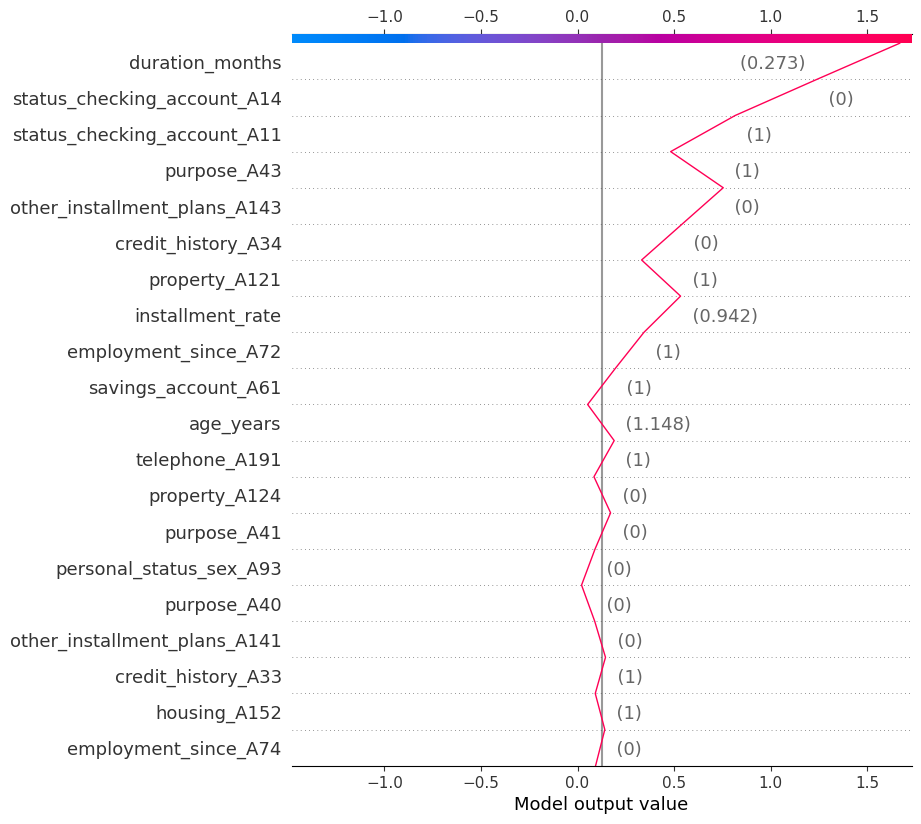

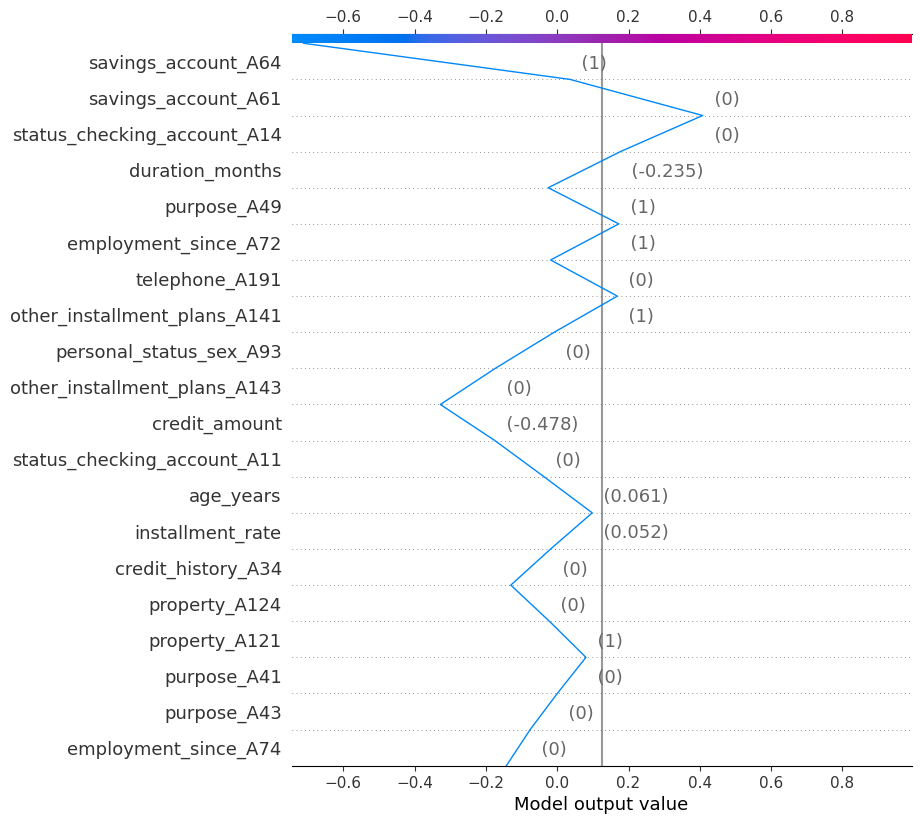

In [16]:
# Local SHAP decision plots for one good and one bad borrower (balanced model)

# We need SHAP values aligned to X_test for local explanations
shap_values_test_bal = explainer_bal.shap_values(X_test)
if isinstance(shap_values_test_bal, list):
    shap_values_test_bal = shap_values_test_bal[1]

good_idx = None
bad_idx = None

for i, y in enumerate(y_test.values):
    if y == 1 and good_idx is None:
        good_idx = i
    if y == 0 and bad_idx is None:
        bad_idx = i
    if good_idx is not None and bad_idx is not None:
        break

print("Good idx:", good_idx, "Bad idx:", bad_idx)

if good_idx is not None:
    plot_shap_decision_for_index(
        explainer_bal,
        shap_values_test_bal,
        X_test,
        good_idx,
        cfg,
        prefix="good_balanced",
    )

if bad_idx is not None:
    plot_shap_decision_for_index(
        explainer_bal,
        shap_values_test_bal,
        X_test,
        bad_idx,
        cfg,
        prefix="bad_balanced",
    )

for prefix, idx in [("good_balanced", good_idx), ("bad_balanced", bad_idx)]:
    if idx is None:
        continue
    fname = f"shap_decision_{prefix}_{idx}.png"
    path = os.path.join(cfg.reports_dir, fname)
    if os.path.exists(path):
        display(Image(filename=path, width=500))
    else:
        print("Missing:", path)


### How to read the decision plots

- The x-axis shows the **model output** (log-odds for the Bad class, or an equivalent transformed score).  
- Features that move the curve **to the right** increase the predicted probability of **Bad** (higher default risk).  
- Features that move the curve **to the left** decrease the predicted probability of Bad (more likely **Good**).  
- Features are ordered by their **absolute SHAP impact** for that specific borrower.

### Bad borrower (top plot, `bad_idx = 0`, `y = 1`)

- Unfavourable checking-account status (`status_checking_account_A14 = 1`), longer `duration_months`and high `credit_amount` push the curve strongly **to the right**, raising the risk score.  
- Any positive features (e.g. some savings/employment categories) pull slightly left, but they are not enough to offset the large rightward pushes.  
- The final point on the curve lies well on the Bad side, explaining why this borrower is classified as high risk.

### Good borrower (bottom plot, `good_idx = 2`, `y = 0`)

- Favourable savings and checking-account indicators (e.g. `savings_account_A61 = 1`) pull the curve **to the left**, reducing the predicted probability of Bad.  
- Moderate `credit_amount` and other benign features keep the risk score low.  
- Some characteristics (such as certain account or employment statuses) may nudge the curve slightly to the right, but the net effect remains strongly towards **Good**.

These local explanations are useful for:

- Debugging model behaviour on individual cases,  
- Providing evidence to risk or model-validation teams,  
- Forming the basis of **reason codes** for adverse-action notices when applications are declined.

## Sensitivity analysis: “what if we changed this feature?”

Finally, we turn SHAP into a simple **what-if analysis** tool, using the balanced tuned model.

For several representative **Good** and **Bad** borrowers we:

1. Identify the **top features** (by absolute SHAP value) for that borrower.  
2. For each feature, sweep a range of plausible values while keeping all other features fixed.  
3. For every value, recompute the model’s **predicted probability of good credit** $(P(\text{Good}))$  on the y-axis.  
   (Since `Bad = 1` in the model, $P(\text{Bad}) = 1 - P(\text{Good})$.)  
4. Plot $(P(\text{Good}))$  vs the feature value.

In [17]:
# Sensitivity analysis for top SHAP features (good and bad examples, balanced model)

sens_results = {}

if good_idx is not None:
    sens_results["good_balanced"] = run_sensitivity_for_instance(
        model=best_xgb_balanced,
        X=X_test,
        shap_values=shap_values_test_bal,
        cfg=cfg,
        instance_idx=good_idx,
        top_n=3,
    )

if bad_idx is not None:
    sens_results["bad_balanced"] = run_sensitivity_for_instance(
        model=best_xgb_balanced,
        X=X_test,
        shap_values=shap_values_test_bal,
        cfg=cfg,
        instance_idx=bad_idx,
        top_n=3,
    )

print("Sensitivity keys:", list(sens_results.keys()))
for k, v in sens_results.items():
    print(f"\nInstance type: {k}")
    for feat, pairs in v.items():
        print(f"  Feature: {feat}, #points: {len(pairs)}")


Sensitivity keys: ['good_balanced', 'bad_balanced']

Instance type: good_balanced
  Feature: duration_months, #points: 20
  Feature: status_checking_account_A14, #points: 20
  Feature: status_checking_account_A11, #points: 20

Instance type: bad_balanced
  Feature: savings_account_A64, #points: 20
  Feature: savings_account_A61, #points: 20
  Feature: status_checking_account_A14, #points: 20


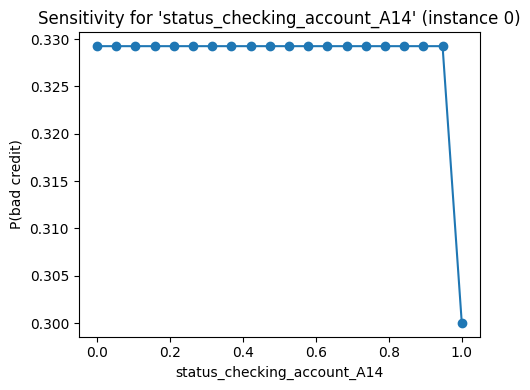

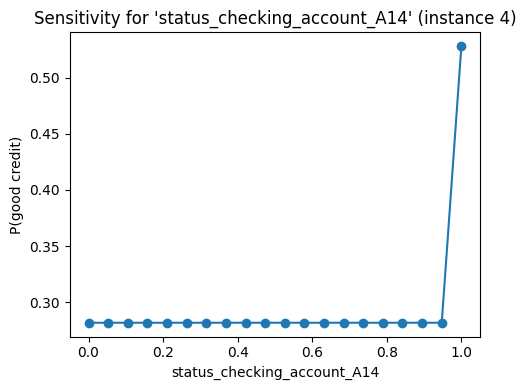

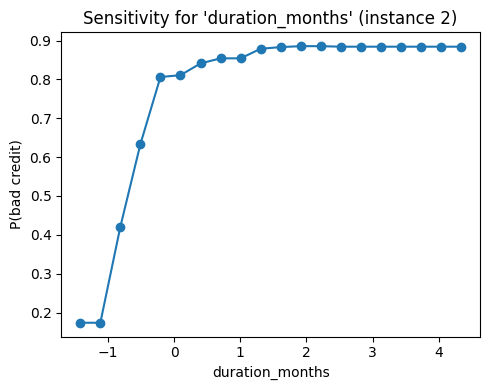

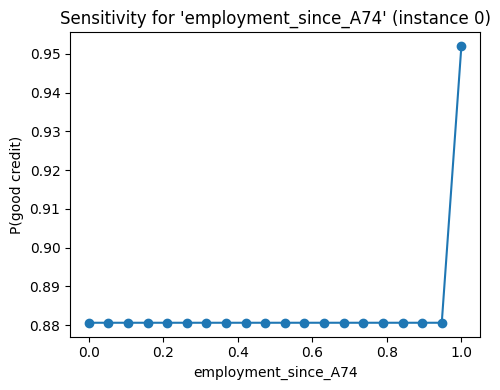

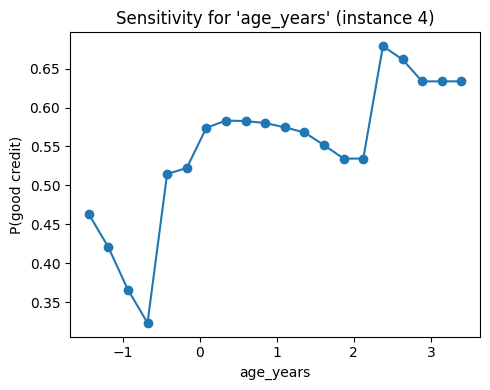

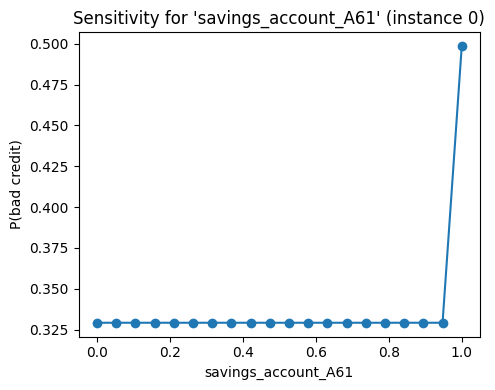

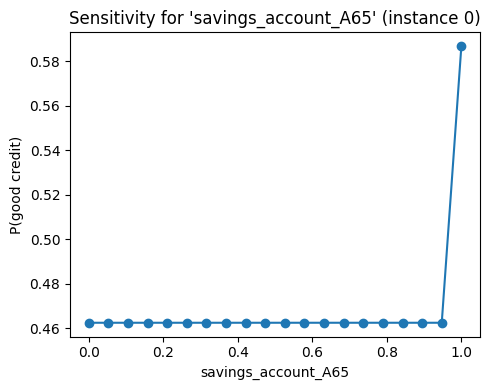

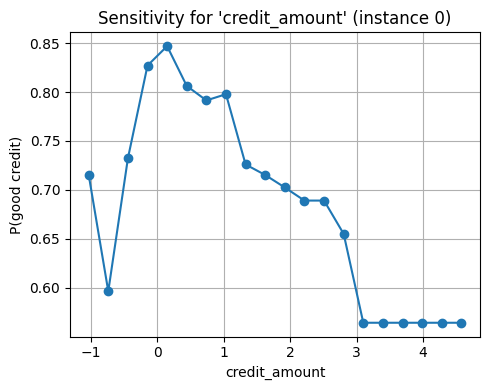

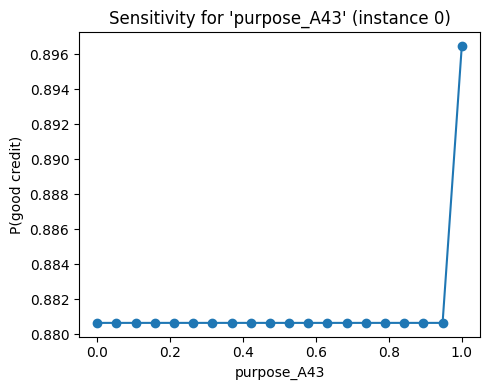

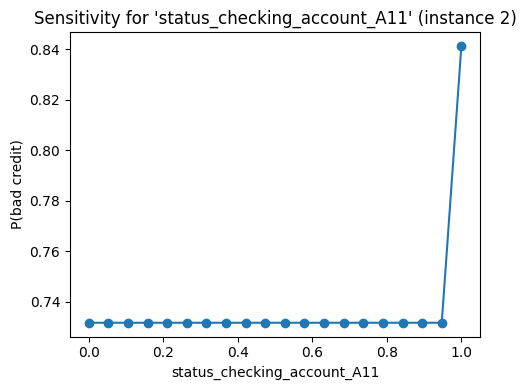

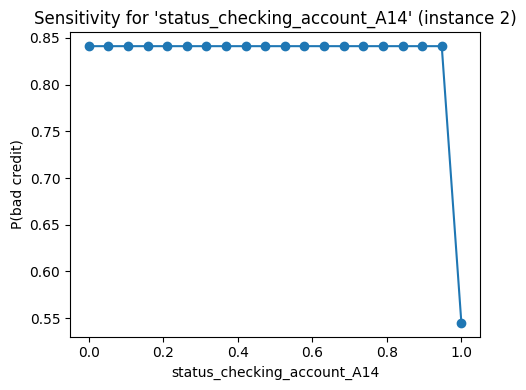

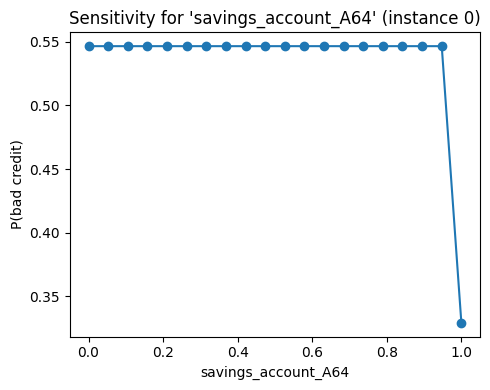

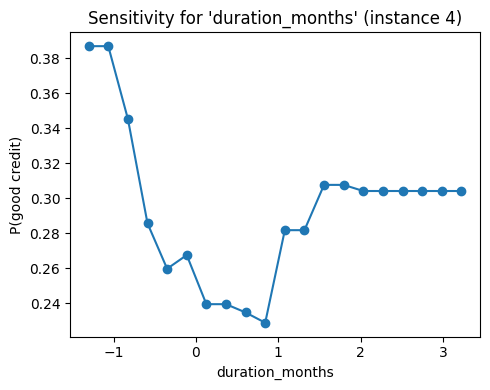

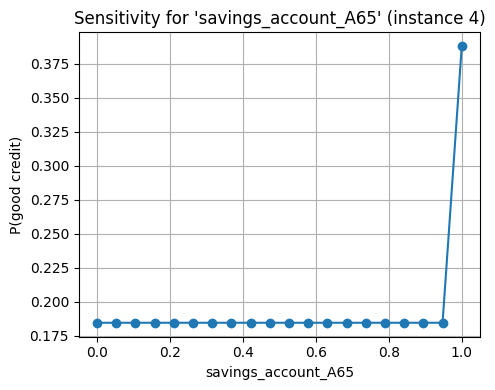

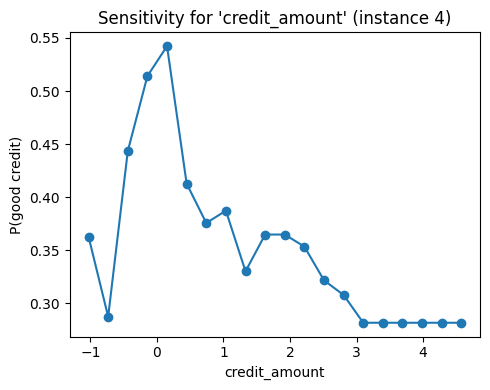

In [18]:
# Display saved sensitivity plots (balanced model)

sens_files = [
    f
    for f in os.listdir(cfg.reports_dir)
    if f.startswith("sensitivity_") and f.endswith(".png")
]

for fname in sens_files:
    path = os.path.join(cfg.reports_dir, fname)
    display(Image(filename=path, width=300))

### Continuous features: `age_years`, `credit_amount`, `duration_months`

From the ICE plots we can see:

- **`age_years` (instance 4)**  
  For this borrower, very young ages are associated with a lower probability of being Good, while the probability increases steadily with age and is highest at middle-to-older ages. The model effectively treats older borrowers as safer than very young ones for this profile.

- **`credit_amount` (instances 0 and 4)**  
  For both borrowers, the relationship is hump-shaped rather than monotonic. Very small and very large loan amounts are treated as riskier, whereas **moderate** loan sizes give the highest predicted probability of being Good. In other words, the model is most comfortable with borrowers asking for a “middle” loan size.

- **`duration_months` (instances 2 and 4)**  
  The effect of duration is clearly borrower-specific:
  - For one borrower (instance 2), increasing the term sharply increases the predicted probability of being Good and then levels off, so longer durations look safer.
  - For the other borrower (instance 4), medium durations are actually the riskiest, with somewhat safer predictions at very short and very long terms.
  This shows that there is no global “longer is better/worse” rule; duration interacts with the rest of the feature profile.

### Binary / categorical features: account and savings indicators

The binary dummy variables create **step changes** in the predicted probability rather than smooth curves:

- **`employment_since_A74` (instance 0)**  
  Turning this category on noticeably increases the probability of being Good, so this employment history is a strong positive signal.

- **`purpose_A43` (instance 0)**  
  Switching this purpose category on gives a small but consistent improvement in the model’s view of the borrower.

- **Savings indicators**  
  Different savings categories have very different meanings:
  - Some, such as `savings_account_A61` and `savings_account_A65`, clearly increase the probability of being Good when they are present.
  - Others, such as `savings_account_A64`, actually reduce the predicted probability and make the borrower look riskier.
  Overall, the model treats certain savings patterns as strong positives and others as negatives.

- **Checking-account indicators**  
  - `status_checking_account_A11` gives a modest increase in the probability of being Good when active.  
  - `status_checking_account_A14` is more complex: for some borrowers it is favourable (probability goes up when A14 = 1), while for at least one borrower it is unfavourable (probability drops).  
  This confirms that the same category can help or hurt depending on the surrounding features; the effect of these account-status dummies is highly context-dependent.

### Takeaways

Across all sensitivity plots:

- Some **binary indicators** (checking-account and savings-account dummies, employment, purpose) act like **on-off switches** for risk, shifting $(P(\text{Good}))$ by 5-25 percentage points when flipped.  
- Continuous variables such as `age_years`, `credit_amount`and `duration_months` exhibit **non-linear, borrower-specific patterns**:  
  - often with **“sweet spots”** where risk is lowest,  
  - and extremes (very young/old, very small/large or very short/long loans) that look riskier.  

This kind of analysis is useful for:

- Understanding **local non-linearities** in the model,  
- Explaining to stakeholders how much “room for improvement” a borderline borrower might have,  
- Stress-testing the model under hypothetical changes to borrower attributes.

### 6. “Putting it all together” summary

1. **Baseline models**
   - Logistic regression and the baseline XGBoost have very similar overall performance (ROC AUC is around 0.8 for both).
   - XGBoost is a bit better at identifying Good borrowers, while logistic regression is slightly better at catching Bad borrowers.
   - In other words, the untuned tree model does not clearly beat the simpler linear model.

2. **Tuned & balanced XGBoost**
   - Hyperparameter tuning by itself gives only a modest change in behaviour.
   - Adding class weights makes the model more focused on Bad borrowers: it lets fewer Bad cases slip through, but wrongly rejects more Good borrowers.
   - This reflects a deliberate shift toward safety (avoiding defaults) rather than maximizing approvals.

3. **Business-aware threshold**
   - When we encode that missing a Bad borrower is much more costly than rejecting a Good one, the optimal decision threshold moves below 0.5.
   - This lower threshold makes the lending policy more conservative: more risky applicants are flagged, at the cost of turning down more borderline Good applicants.

4. **Calibrated probabilities**
   - Probability calibration slightly improves the fit between predicted probabilities and observed default rates.
   - After calibration, the scores are more reliable as “probability of default” estimates, which is helpful for risk-based pricing and policy decisions.


By the end of this walkthrough, we have moved from a raw credit dataset to a tuned,
class-balanced, cost-aware, calibratedand fully-explained credit-scoring model.
Along the way we saw that:

- Logistic regression and untuned XGBoost gave almost identical performance.
- Tuning delivered modest but real gains in ranking quality.
- Handling class imbalance dramatically changed **which borrowers** the model
  prioritizes.
- Threshold selection turned out to be a **business decision**, driven by the cost of
  false approvals vs false rejections.
- Calibration reminded us that good discrimination (AUC) does not guarantee reliable
  probability estimates.
- SHAP and sensitivity analysis tied everything together by revealing which features
  the model relies on globally and how each borrower is evaluated locally under
  different hypothetical scenarios.